# Install the needed packages

%pip install datasets
%pip install transformers
%pip install sentencepiece
%pip install diffusers --upgrade
%pip install invisible_watermark accelerate safetensors
%pip install accelerate
%pip install jiwer
%pip install evaluate

In [19]:
import pandas as pd
import datasets
import torch
from transformers import AutoProcessor,TrainingArguments, Trainer, AutoTokenizer
from transformers import AutoModelForCausalLM
from PIL import Image, ImageFile
from datasets import load_metric
import numpy as np
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True
PYTORCH_CUDA_ALLOC_CONF=expandable_segments = True
from transformers import EarlyStoppingCallback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load the dataset

We check if the dataset is already present in the system, by checking the local variables. If it is not present we load it, else we just skip it. This is done to avoid loading the dataset again and again, as it takes time to load the dataset.

## Data to Keep
Since in this notebook we only Fine-Tune the Captioning model we only keep the descriptions of the paintings, which we scraped from the urls provided in the original dataset.

In [2]:
if 'data' not in locals():
    data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
    data = data.sample(frac=1).reset_index(drop=True)
    data = data.iloc[:20000]
    data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style','URL':'description'})
    data = data[['image','description']]
    data['image'] = [f'.{x}' for x in data['image']]
data.head()

,image,description
0,../images/618.jpg,The picture shows the central part of the fresco.
1,../images/8630.jpg,Van ClÃ¨ve studied Annibale Carracci's frescoe...
2,../images/31284.jpg,"In the United States, as in France, Neoclassic..."
3,../images/12009.jpg,The central scene represents the Nativity. Mar...
4,../images/2577.jpg,This impressive maiolica plate was part of a s...


In [3]:
print(data.columns)

Index(['image', 'description'], dtype='object')


In [4]:
dataset = datasets.Dataset.from_pandas(data).cast_column('image', datasets.Image())
print(dataset)

Dataset({
    features: ['image', 'description'],
    num_rows: 20000
})


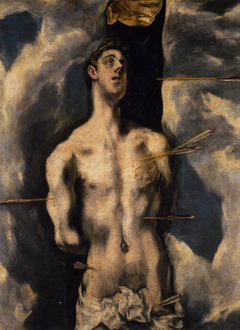

This is a fragment from the later period of the artist.


In [5]:
sample = dataset[53]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
caption = sample['description']
print(caption)

# The Model

For our task, we opted for the Git-large-Coco model provided by Microsoft. This model is a large-scale language model trained on the Coco dataset, which shares similarities with our dataset as it consists of images paired with textual descriptions. Among the models available on Hugging Face, we found that the Git-large-Coco model consistently yielded superior results for our specific task.

In addition to the model itself, we utilized the associated processor. This processor aligns with the one used during the original training of the model. Ensuring consistency between the model and its processor is crucial, as the processor plays a key role in tokenizing input data. Mismatched processors could result in the model being unable to interpret input data correctly. By leveraging the pre-existing processor, we save significant time and effort that would otherwise be required to develop and fine-tune our own processor.


In [6]:
checkpoint_capt= "microsoft/git-large-coco"
processor_capt = AutoProcessor.from_pretrained(checkpoint_capt)

# Data Preprocessing

To facilitate data feeding into the processor and obtain tokenized inputs for the model, we define a function named `capt_transforms`. This function transforms the raw data into a format suitable for the model input. Here's a breakdown of the process:

## Function Description
The `capt_transforms` function takes an example batch containing images and captions as input. It performs the following steps:

1. **Extract Images and Captions**:
   - Extracts images and captions from the example batch.

2. **Tokenization**:
   - Utilizes the pre-trained processor (`processor_capt`) to tokenize the images and captions.
   - Sets the maximum sequence length for padding and truncates sequences if needed.
   - Returns a DatasetDict containing tokenized inputs with keys "input_ids" and "labels".

## Input and Output
- **Input**: Example batch containing images and captions.
- **Output**: Tokenized inputs suitable for model ingestion, comprising input IDs and corresponding labels.

## Data Processing Improvements
- **Efficient Transformation**: The function efficiently transforms raw data into tokenized inputs using the pre-trained processor, ensuring compatibility with the model's input requirements.
- **Padding and Truncation**: Utilizes padding and truncation to handle sequences of varying lengths, enabling uniform input sizes for the model.
- **Label Generation**: Generates labels from input IDs, facilitating model training and evaluation.

By employing this data preprocessing function, we streamline the pipeline for preparing inputs to the model, ultimately enhancing efficiency and compatibility with downstream tasks.


In [7]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["description"]]
    inputs = processor_capt(images=images, text=captions, padding='max_length', truncation=True, return_tensors="pt")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

In [8]:
#Caption
capt_dataset = dataset.train_test_split(test_size=0.3)
capt_dataset = capt_dataset.with_transform(transforms)

# Evaluation

In assessing the performance of our model, we employed the ROUGE score, a widely used metric for evaluating image captioning in generative models. The ROUGE score measures the similarity between generated captions and ground truth captions by comparing overlapping n-grams, thereby providing insights into the quality and accuracy of the generated captions.

To compute the ROUGE score, we utilized the `load_metric` function from the `datasets` library, specifically loading the ROUGE metric for evaluation purposes.
We then defined a custom function named `capt_compute_metrics` to compute the ROUGE score for evaluation. This function takes `eval_pred` as input, which contains logits (model predictions) and labels (ground truth captions).

The function performs the following steps:

1. Extracts logits (model predictions) and labels (ground truth captions) from the `eval_pred` input.
2. Decodes the labels and predictions using the associated processor (`processor_capt`), skipping special tokens to obtain human-readable text.
3. Computes the ROUGE score using the decoded predictions and references (ground truth captions).
4. Returns a dictionary containing the computed ROUGE score under the key "rouge_score".

By utilizing the ROUGE score and implementing a custom evaluation function, we gain valuable insights into the quality of our model's generated captions compared to ground truth captions. This facilitates quantitative assessment and refinement of the model's performance, ultimately contributing to its effectiveness in generating accurate and relevant captions for images.


In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint_capt)

We need to preprocess the data before evaluation because the trainer function has a problem of memory leaks.

In [10]:
def preprocess_logits_for_metrics(logits,labels):
    predictions = torch.argmax(logits, dim=-1)
    return predictions,labels

In [11]:
import evaluate

In [12]:
rouge = evaluate.load('rouge')
def capt_compute_metrics(eval_pred):
    logits, labels = eval_pred
    pred_ids = logits[0]
    pred_ids = processor_capt.batch_decode(pred_ids, skip_special_tokens=True)
    labels = processor_capt.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=pred_ids, references=labels, use_aggregator=True)
    return result

In [13]:
# from transformers import CLIPProcessor, CLIPModel

# clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor_clip = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# def clip_compute_metrics(eval_pred):
#     references = eval_pred.label_ids
#     generated_text = eval_pred.predictions[1]

#     references = processor_clip.batch_decode(references, skip_special_tokens=True)
#     generated_text = processor_clip.batch_decode(generated_text, skip_special_tokens=True)

#     # Calculate the BERTScore
#     result = clip.compute(predictions=generated_text, references=references)
#     print(result)
#     return result["f1"].mean()

# Fine tuning

In this notebook we decide to use the HuggingFace trainer since it is a very easy to use and powerful tool to fine-tune models. This saved us time in writing our own custom training loop as the hugging face model serves us as a comparison for our custom models, which we train in a different notebook.

In [14]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Hyperparameters Optimization



In [15]:
def model_init(trial):
    return AutoModelForCausalLM.from_pretrained(checkpoint_capt).to(device)

In [16]:
torch.cuda.empty_cache()

capt_training_args = TrainingArguments(
    output_dir="model_checkpoints/captioning",
    learning_rate=1e-5,
    num_train_epochs=5,
    warmup_ratio=0.2,
    fp16=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

capt_trainer = Trainer(
    # model=model_capt,
    model_init=model_init,
    args=capt_training_args,
    data_collator=data_collator,
    train_dataset=capt_dataset["train"],
    eval_dataset=capt_dataset["test"],
    compute_metrics=capt_compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

torch.cuda.empty_cache()

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [17]:
#HyperParameter Search

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [6,8]),
        "gradient_accumulation_steps": trial.suggest_int("gradient_accumulation_steps", 1, 4),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [6,8]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.1, 0.3),
    }

In [18]:
best_trials = capt_trainer.hyperparameter_search(n_trials=10,
                                                 backend="optuna",
                                                 hp_space=optuna_hp_space, 
                                                 direction="maximize",)

[I 2024-05-18 12:55:53,053] A new study created in memory with name: no-name-d3bb88c6-b5d2-44b3-ab01-c0f7e710f0f8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


  0%|          | 0/875 [00:00<?, ?it/s]

{'loss': 2.9181, 'learning_rate': 1.5826645888505617e-05, 'epoch': 0.57}


  0%|          | 0/1000 [00:00<?, ?it/s]

{'eval_loss': 1.0149412155151367, 'eval_rouge1': 0.14480009897790283, 'eval_rouge2': 0.03269451410637356, 'eval_rougeL': 0.10831880153043305, 'eval_rougeLsum': 0.10834321793945698, 'eval_runtime': 422.8828, 'eval_samples_per_second': 14.188, 'eval_steps_per_second': 2.365, 'epoch': 1.0}


[I 2024-05-18 17:16:34,877] Trial 0 finished with value: 0.39415663255416644 and parameters: {'learning_rate': 3.123124788665108e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'per_device_eval_batch_size': 6, 'warmup_ratio': 0.15410749436440235}. Best is trial 0 with value: 0.39415663255416644.


{'train_runtime': 15640.5219, 'train_samples_per_second': 0.895, 'train_steps_per_second': 0.056, 'train_loss': 2.1202169015066965, 'epoch': 1.0}


c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


eval/loss,▁
eval/rouge1,▁
eval/rouge2,▁
eval/rougeL,▁
eval/rougeLsum,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁██
train/global_step,▁██
train/learning_rate,▁


  0%|          | 0/583 [00:00<?, ?it/s]

{'loss': 4.0938, 'learning_rate': 2.9638946926369213e-06, 'epoch': 0.86}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 1.1967887878417969, 'eval_rouge1': 0.16133719599443022, 'eval_rouge2': 0.0322079564468032, 'eval_rougeL': 0.11975101810542069, 'eval_rougeLsum': 0.11976626395084955, 'eval_runtime': 442.3169, 'eval_samples_per_second': 13.565, 'eval_steps_per_second': 1.696, 'epoch': 1.0}


[I 2024-05-18 17:42:24,494] Trial 1 finished with value: 0.4330624344975037 and parameters: {'learning_rate': 1.5212278783895523e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 6, 'gradient_accumulation_steps': 4, 'per_device_eval_batch_size': 8, 'warmup_ratio': 0.2678202115706211}. Best is trial 1 with value: 0.4330624344975037.


{'train_runtime': 1545.7693, 'train_samples_per_second': 9.057, 'train_steps_per_second': 0.377, 'train_loss': 3.686843466390672, 'epoch': 1.0}


c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


eval/loss,▁
eval/rouge1,▁
eval/rouge2,▁
eval/rougeL,▁
eval/rougeLsum,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁██
train/global_step,▁██
train/learning_rate,▁


  0%|          | 0/3112 [00:00<?, ?it/s]

{'loss': 4.9409, 'learning_rate': 2.009455896140849e-05, 'epoch': 0.64}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 1.0332151651382446, 'eval_rouge1': 0.15905015739329237, 'eval_rouge2': 0.035062297429192466, 'eval_rougeL': 0.11806873526176065, 'eval_rougeLsum': 0.11809625373999522, 'eval_runtime': 997.5284, 'eval_samples_per_second': 6.015, 'eval_steps_per_second': 0.752, 'epoch': 1.0}
{'loss': 1.0683, 'learning_rate': 1.6247974167877004e-05, 'epoch': 1.29}
{'loss': 0.9932, 'learning_rate': 1.2401389374345514e-05, 'epoch': 1.93}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.9683454036712646, 'eval_rouge1': 0.1555260801967826, 'eval_rouge2': 0.03646926933960203, 'eval_rougeL': 0.11474830486501428, 'eval_rougeLsum': 0.11479040283771375, 'eval_runtime': 627.9916, 'eval_samples_per_second': 9.554, 'eval_steps_per_second': 1.194, 'epoch': 2.0}
{'loss': 0.9422, 'learning_rate': 8.554804580814027e-06, 'epoch': 2.57}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.9447664618492126, 'eval_rouge1': 0.15743047128960747, 'eval_rouge2': 0.03788004269422238, 'eval_rougeL': 0.1156754683696013, 'eval_rougeLsum': 0.11569273954667986, 'eval_runtime': 645.5592, 'eval_samples_per_second': 9.294, 'eval_steps_per_second': 1.162, 'epoch': 3.0}
{'loss': 0.9249, 'learning_rate': 4.7082197872825405e-06, 'epoch': 3.21}
{'loss': 0.8942, 'learning_rate': 8.616349937510532e-07, 'epoch': 3.86}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.9390530586242676, 'eval_rouge1': 0.16129048231335344, 'eval_rouge2': 0.039010531365613034, 'eval_rougeL': 0.11860916679041592, 'eval_rougeLsum': 0.11865298613169362, 'eval_runtime': 650.3858, 'eval_samples_per_second': 9.225, 'eval_steps_per_second': 1.153, 'epoch': 4.0}


[I 2024-05-18 22:12:03,948] Trial 2 finished with value: 0.43756316660107597 and parameters: {'learning_rate': 2.0494603779935764e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 6, 'gradient_accumulation_steps': 3, 'per_device_eval_batch_size': 8, 'warmup_ratio': 0.14388112172513454}. Best is trial 2 with value: 0.43756316660107597.


{'train_runtime': 16175.9388, 'train_samples_per_second': 3.462, 'train_steps_per_second': 0.192, 'train_loss': 1.6036660236074256, 'epoch': 4.0}


c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


eval/loss,█▃▁▁
eval/rouge1,▅▁▃█
eval/rouge2,▁▃▆█
eval/rougeL,▇▁▃█
eval/rougeLsum,▇▁▃█
eval/runtime,█▁▁▁
eval/samples_per_second,▁█▇▇
eval/steps_per_second,▁█▇▇
train/epoch,▁▂▂▄▄▅▆▆███
train/global_step,▁▂▂▄▄▅▆▆███
train/learning_rate,█▇▅▄▂▁


  0%|          | 0/3500 [00:00<?, ?it/s]

{'loss': 5.1459, 'learning_rate': 2.1280577363784108e-05, 'epoch': 0.29}
{'loss': 1.1183, 'learning_rate': 3.509031373815465e-05, 'epoch': 0.57}
{'loss': 1.0559, 'learning_rate': 2.8072250990523722e-05, 'epoch': 0.86}


  0%|          | 0/1000 [00:00<?, ?it/s]

{'eval_loss': 0.9847855567932129, 'eval_rouge1': 0.14659807525088267, 'eval_rouge2': 0.03341504849029496, 'eval_rougeL': 0.10951935296080414, 'eval_rougeLsum': 0.10953906330638549, 'eval_runtime': 704.9506, 'eval_samples_per_second': 8.511, 'eval_steps_per_second': 1.419, 'epoch': 1.0}
{'loss': 0.9895, 'learning_rate': 2.1054188242892792e-05, 'epoch': 1.14}
{'loss': 0.9434, 'learning_rate': 1.4036125495261861e-05, 'epoch': 1.43}
{'loss': 0.9636, 'learning_rate': 7.0180627476309305e-06, 'epoch': 1.71}
{'loss': 0.9112, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/1000 [00:00<?, ?it/s]

{'eval_loss': 0.9407439827919006, 'eval_rouge1': 0.15179529186411866, 'eval_rouge2': 0.036446838740063464, 'eval_rougeL': 0.11404352122268324, 'eval_rougeLsum': 0.11410605096828719, 'eval_runtime': 713.0659, 'eval_samples_per_second': 8.414, 'eval_steps_per_second': 1.402, 'epoch': 2.0}


[I 2024-05-19 01:50:21,625] Trial 3 finished with value: 0.4163917027951526 and parameters: {'learning_rate': 3.6943082303529215e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'per_device_eval_batch_size': 6, 'warmup_ratio': 0.24798173778566537}. Best is trial 2 with value: 0.43756316660107597.


{'train_runtime': 13094.3228, 'train_samples_per_second': 2.138, 'train_steps_per_second': 0.267, 'train_loss': 1.5896890433175224, 'epoch': 2.0}


c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


eval/loss,█▁
eval/rouge1,▁█
eval/rouge2,▁█
eval/rougeL,▁█
eval/rougeLsum,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂▃▄▄▆▇███
train/global_step,▁▂▃▄▅▆▇███
train/learning_rate,▅█▇▅▄▂▁


  0%|          | 0/4668 [00:00<?, ?it/s]

{'loss': 4.5954, 'learning_rate': 2.8818254926945633e-05, 'epoch': 0.43}
{'loss': 1.0777, 'learning_rate': 3.989186201801839e-05, 'epoch': 0.86}


  0%|          | 0/1000 [00:00<?, ?it/s]

{'eval_loss': 0.9959990382194519, 'eval_rouge1': 0.14433088125857324, 'eval_rouge2': 0.03248034169822164, 'eval_rougeL': 0.1080458169936339, 'eval_rougeLsum': 0.10809176214295618, 'eval_runtime': 753.0145, 'eval_samples_per_second': 7.968, 'eval_steps_per_second': 1.328, 'epoch': 1.0}
{'loss': 0.9892, 'learning_rate': 3.445404004173453e-05, 'epoch': 1.29}
{'loss': 0.9622, 'learning_rate': 2.901621806545067e-05, 'epoch': 1.71}


  0%|          | 0/1000 [00:00<?, ?it/s]

{'eval_loss': 0.9353002309799194, 'eval_rouge1': 0.14627526249085665, 'eval_rouge2': 0.0347174816672096, 'eval_rougeL': 0.1104509546556104, 'eval_rougeLsum': 0.11049679408796301, 'eval_runtime': 757.3801, 'eval_samples_per_second': 7.922, 'eval_steps_per_second': 1.32, 'epoch': 2.0}
{'loss': 0.9023, 'learning_rate': 2.3578396089166813e-05, 'epoch': 2.14}
{'loss': 0.8827, 'learning_rate': 1.8140574112882952e-05, 'epoch': 2.57}
{'loss': 0.8856, 'learning_rate': 1.2702752136599093e-05, 'epoch': 3.0}


  0%|          | 0/1000 [00:00<?, ?it/s]

{'eval_loss': 0.911203920841217, 'eval_rouge1': 0.14933656862741815, 'eval_rouge2': 0.03675107981257328, 'eval_rougeL': 0.11289170327470525, 'eval_rougeLsum': 0.11294023652494659, 'eval_runtime': 717.1336, 'eval_samples_per_second': 8.367, 'eval_steps_per_second': 1.394, 'epoch': 3.0}
{'loss': 0.8331, 'learning_rate': 7.264930160315235e-06, 'epoch': 3.43}
{'loss': 0.8342, 'learning_rate': 1.8271081840313765e-06, 'epoch': 3.86}


  0%|          | 0/1000 [00:00<?, ?it/s]

{'eval_loss': 0.9018682241439819, 'eval_rouge1': 0.15150859839321357, 'eval_rouge2': 0.038151388432603475, 'eval_rougeL': 0.1148852491392835, 'eval_rougeLsum': 0.11493157838877166, 'eval_runtime': 713.659, 'eval_samples_per_second': 8.407, 'eval_steps_per_second': 1.401, 'epoch': 4.0}


[I 2024-05-19 05:06:17,294] Trial 4 finished with value: 0.4194768143538722 and parameters: {'learning_rate': 4.270865380173343e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 6, 'gradient_accumulation_steps': 2, 'per_device_eval_batch_size': 6, 'warmup_ratio': 0.15865374556022727}. Best is trial 2 with value: 0.43756316660107597.


{'train_runtime': 11752.0046, 'train_samples_per_second': 4.765, 'train_steps_per_second': 0.397, 'train_loss': 1.3138684989451954, 'epoch': 4.0}


c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


eval/loss,█▃▂▁
eval/rouge1,▁▃▆█
eval/rouge2,▁▄▆█
eval/rougeL,▁▃▆█
eval/rougeLsum,▁▃▆█
eval/runtime,▇█▂▁
eval/samples_per_second,▂▁▇█
eval/steps_per_second,▂▁▇█
train/epoch,▁▂▂▃▄▄▄▅▆▆▇███
train/global_step,▁▂▂▃▄▄▄▅▆▆▇███
train/learning_rate,▆█▇▆▅▄▃▂▁


  0%|          | 0/1556 [00:00<?, ?it/s]

{'loss': 3.1857, 'learning_rate': 4.3626370165467226e-05, 'epoch': 0.64}


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-19 05:33:48,076] Trial 5 pruned. 


{'eval_loss': 0.9883716106414795, 'eval_rouge1': 0.14535332281650318, 'eval_rouge2': 0.0326854788356367, 'eval_rougeL': 0.1080016018301917, 'eval_rougeLsum': 0.10802059984704585, 'eval_runtime': 409.8398, 'eval_samples_per_second': 14.64, 'eval_steps_per_second': 2.44, 'epoch': 1.0}


eval/loss,▁
eval/rouge1,▁
eval/rouge2,▁
eval/rougeL,▁
eval/rougeLsum,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁█
train/global_step,▁█
train/learning_rate,▁


  0%|          | 0/7000 [00:00<?, ?it/s]

{'loss': 6.6956, 'learning_rate': 9.948683993720819e-06, 'epoch': 0.29}
{'loss': 1.3693, 'learning_rate': 1.9897367987441638e-05, 'epoch': 0.57}
{'loss': 1.0893, 'learning_rate': 2.984605198116246e-05, 'epoch': 0.86}


  0%|          | 0/750 [00:00<?, ?it/s]

[I 2024-05-19 06:36:01,843] Trial 6 pruned. 


{'eval_loss': 1.0178534984588623, 'eval_rouge1': 0.13940699119102534, 'eval_rouge2': 0.030542995634208352, 'eval_rougeL': 0.10350970166859498, 'eval_rougeLsum': 0.10353198224502455, 'eval_runtime': 396.9578, 'eval_samples_per_second': 15.115, 'eval_steps_per_second': 1.889, 'epoch': 1.0}


eval/loss,▁
eval/rouge1,▁
eval/rouge2,▁
eval/rougeL,▁
eval/rougeLsum,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▄▇█
train/global_step,▁▄▇█
train/learning_rate,▁▄█


  0%|          | 0/5250 [00:00<?, ?it/s]

{'loss': 5.1721, 'learning_rate': 2.1081105226352033e-05, 'epoch': 0.29}
{'loss': 1.1228, 'learning_rate': 4.2162210452704065e-05, 'epoch': 0.57}
{'loss': 1.0641, 'learning_rate': 5.811169472723897e-05, 'epoch': 0.86}


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-19 07:29:42,198] Trial 7 pruned. 


{'eval_loss': 0.9869903326034546, 'eval_rouge1': 0.14097844563711537, 'eval_rouge2': 0.03190900448437038, 'eval_rougeL': 0.10499808487614985, 'eval_rougeLsum': 0.1050294280465442, 'eval_runtime': 635.3965, 'eval_samples_per_second': 9.443, 'eval_steps_per_second': 1.574, 'epoch': 1.0}


eval/loss,▁
eval/rouge1,▁
eval/rouge2,▁
eval/rougeL,▁
eval/rougeLsum,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▄▇█
train/global_step,▁▄▇█
train/learning_rate,▁▅█


  0%|          | 0/3500 [00:00<?, ?it/s]

{'loss': 5.5475, 'learning_rate': 1.49568274946375e-05, 'epoch': 0.57}


  0%|          | 0/750 [00:00<?, ?it/s]

[I 2024-05-19 08:51:56,836] Trial 8 pruned. 


{'eval_loss': 1.0445986986160278, 'eval_rouge1': 0.14337544625770168, 'eval_rouge2': 0.03158299365177118, 'eval_rougeL': 0.10630930429755406, 'eval_rougeLsum': 0.1062970572541562, 'eval_runtime': 394.9902, 'eval_samples_per_second': 15.19, 'eval_steps_per_second': 1.899, 'epoch': 1.0}


eval/loss,▁
eval/rouge1,▁
eval/rouge2,▁
eval/rougeL,▁
eval/rougeLsum,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁█
train/global_step,▁█
train/learning_rate,▁


  0%|          | 0/1556 [00:00<?, ?it/s]

{'loss': 4.6195, 'learning_rate': 1.8292624150386e-05, 'epoch': 0.64}


  0%|          | 0/750 [00:00<?, ?it/s]

[I 2024-05-19 09:19:27,685] Trial 9 pruned. 


{'eval_loss': 1.0400846004486084, 'eval_rouge1': 0.14484947035570164, 'eval_rouge2': 0.03159670744419116, 'eval_rougeL': 0.1074400070914322, 'eval_rougeLsum': 0.10748156471914312, 'eval_runtime': 582.9229, 'eval_samples_per_second': 10.293, 'eval_steps_per_second': 1.287, 'epoch': 1.0}


## Fine Tune with best parameters

In [15]:
model_capt = AutoModelForCausalLM.from_pretrained(checkpoint_capt).to(device)

In [20]:
torch.cuda.empty_cache()
best_hyperparameters = {'learning_rate': 2.0494603779935764e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 6, 'gradient_accumulation_steps': 3, 'per_device_eval_batch_size': 8, 'warmup_ratio': 0.14388112172513454}

capt_training_args = TrainingArguments(
    output_dir="model_checkpoints/captioning",
    learning_rate=best_hyperparameters["learning_rate"],
    num_train_epochs=best_hyperparameters["num_train_epochs"],
    fp16=False,
    per_device_train_batch_size=best_hyperparameters["per_device_train_batch_size"],
    per_device_eval_batch_size=best_hyperparameters["per_device_eval_batch_size"],
    gradient_accumulation_steps=best_hyperparameters["gradient_accumulation_steps"],
    save_total_limit=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

capt_trainer = Trainer(
    model=model_capt,
    args=capt_training_args,
    data_collator=data_collator,
    train_dataset=capt_dataset["train"],
    eval_dataset=capt_dataset["test"],
    compute_metrics=capt_compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

torch.cuda.empty_cache()

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [21]:
# torch.cuda.empty_cache()
# from transformers import EarlyStoppingCallback
# capt_training_args = TrainingArguments(
#     output_dir="model_checkpoints/captioning",
#     learning_rate=1e-5,
#     num_train_epochs=5,
#     warmup_ratio=0.2,
#     fp16=False,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     gradient_accumulation_steps=2,
#     eval_accumulation_steps=1,
#     save_total_limit=2,
#     evaluation_strategy="no",
#     save_strategy="no",
#     remove_unused_columns=False,
#     push_to_hub=False,
#     label_names=["description"],
#     load_best_model_at_end=True,
# )

# capt_trainer = Trainer(
#     model=model_capt,
#     # model_init=model_init,
#     args=capt_training_args,
#     data_collator=data_collator,
#     train_dataset=capt_dataset["train"],
#     eval_dataset=capt_dataset["test"],
#     compute_metrics=capt_compute_metrics,
#     preprocess_logits_for_metrics=preprocess_logits_for_metrics,
# )

# torch.cuda.empty_cache()

In [22]:
capt_trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


  0%|          | 0/3112 [00:00<?, ?it/s]

{'loss': 2.5023, 'learning_rate': 1.7201768982388244e-05, 'epoch': 0.64}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 1.0115524530410767, 'eval_rouge1': 0.14171107682678924, 'eval_rouge2': 0.031799556565640846, 'eval_rougeL': 0.10626585801255453, 'eval_rougeLsum': 0.10623926000160422, 'eval_runtime': 599.7714, 'eval_samples_per_second': 10.004, 'eval_steps_per_second': 1.25, 'epoch': 1.0}
{'loss': 1.0246, 'learning_rate': 1.3908934184840725e-05, 'epoch': 1.29}
{'loss': 0.9793, 'learning_rate': 1.0616099387293203e-05, 'epoch': 1.93}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.9643548130989075, 'eval_rouge1': 0.15124586840997484, 'eval_rouge2': 0.03573024191953254, 'eval_rougeL': 0.11304348149936935, 'eval_rougeLsum': 0.11301880715894064, 'eval_runtime': 1470.9236, 'eval_samples_per_second': 4.079, 'eval_steps_per_second': 0.51, 'epoch': 2.0}
{'loss': 0.9345, 'learning_rate': 7.323264589745684e-06, 'epoch': 2.57}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.9455673694610596, 'eval_rouge1': 0.15522336015271893, 'eval_rouge2': 0.037359885157812106, 'eval_rougeL': 0.11464108646148288, 'eval_rougeLsum': 0.114630579360824, 'eval_runtime': 611.6734, 'eval_samples_per_second': 9.809, 'eval_steps_per_second': 1.226, 'epoch': 3.0}
{'loss': 0.9201, 'learning_rate': 4.030429792198164e-06, 'epoch': 3.21}
{'loss': 0.8961, 'learning_rate': 7.375949946506445e-07, 'epoch': 3.86}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.9412829875946045, 'eval_rouge1': 0.15842235215663036, 'eval_rouge2': 0.038256559328350065, 'eval_rougeL': 0.1168133235409652, 'eval_rougeLsum': 0.11676527050190175, 'eval_runtime': 661.8576, 'eval_samples_per_second': 9.065, 'eval_steps_per_second': 1.133, 'epoch': 4.0}
{'train_runtime': 10460.0263, 'train_samples_per_second': 5.354, 'train_steps_per_second': 0.298, 'train_loss': 1.1991511837682258, 'epoch': 4.0}


TrainOutput(global_step=3112, training_loss=1.1991511837682258, metrics={'train_runtime': 10460.0263, 'train_samples_per_second': 5.354, 'train_steps_per_second': 0.298, 'train_loss': 1.1991511837682258, 'epoch': 4.0})

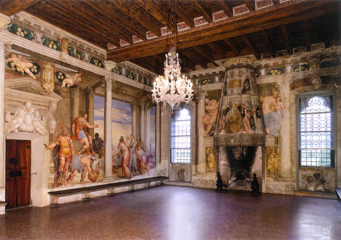

Description: The construction of the Villa Da Porto Colleoni probably began in 1440-41 at the behest of Francesco Da Porto. Its decoration was commissioned in the sixteenth century from Paolo Veronese, Giovanni Battista Zelotti, and Giovanni Antonio Fasolo. Unfortunately, the decoration, with the exception of that in the camerone (large room) was later obliterated.The decoration in the camerone is attributed to Fasolo, with a contribution by Zelotti. Here, inserted within elegant Corinthian loggias on the long wall, are four scenes taken from Roman history: Mucius Scaevola before Porsena and Sofonisba Asking Massinissa for Mercy (east wall), Scipio Returning Lucius's Betrothed and the Banquet of Antony and Cleopatra (west wall). On either side of the fireplace the figures of Vulcan and Venus Holding Cupid, and above the door, the figures of Minerva and Mercury complete the decoration.


In [31]:
sample = dataset[89]
image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
desc = sample['description']
print(f'Description: {desc}')

In [32]:
inputs = processor_capt(images = image, return_tensors='pt').to(device)
pixel_values = inputs.pixel_values

generated_ids = model_capt.generate(pixel_values=pixel_values, max_length=5000)
generated_caption = processor_capt.batch_decode(generated_ids,skip_special_tokens=True)[0]
print(generated_caption)

the picture shows the sala del consiglio ( room of the gods ). the picture shows the interior of the sala del consiglio ( room of the villa ).


In [25]:
model_capt.push_to_hub("Art_huggingface_caption")

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rullo16/Art_huggingface_caption/commit/fc2f99cd75e4ad93dd35cabbb611bfe06d0a62a6', commit_message='Upload GitForCausalLM', commit_description='', oid='fc2f99cd75e4ad93dd35cabbb611bfe06d0a62a6', pr_url=None, pr_revision=None, pr_num=None)